In [1]:
#ツイートのテキスト読み込み
test = open("RNN_tweet/Datas/A_extract_tweet.txt", "r", encoding="utf-8")
lines = test.readlines()
test.close()
print(len(lines))

#ラベル読み込み
test = open("RNN_tweet/Datas/label.txt", "r", encoding="utf-8")
label = test.readlines()
test.close()
print(len(label))

10000
10000


In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.utils.np_utils import to_categorical

maxlen = 50
training_samples = 8000 # training data 80 : validation data 20
validation_samples = len(lines) - training_samples
max_words = 20000

# word indexを作成
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

data = pad_sequences(sequences, maxlen=maxlen)

# バイナリの行列に変換
categorical_labels = to_categorical(label)
labels = np.asarray(categorical_labels)

print("Shape of data tensor:{}".format(data.shape))
print("Shape of label tensor:{}".format(labels.shape))

# 行列をランダムにシャッフルする
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Using TensorFlow backend.


Found 21381 unique tokens.
Shape of data tensor:(10000, 50)
Shape of label tensor:(10000, 2)


In [3]:
import keras.backend as K
from functools import partial

def normalize_y_pred(y_pred):
    return K.one_hot(K.argmax(y_pred), y_pred.shape[-1])

def class_true_positive(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label] + y_pred[:, class_label], 2), K.floatx())

def class_accuracy(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label], y_pred[:, class_label]),
                  K.floatx())

def class_precision(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_pred[:, class_label]) + K.epsilon())


def class_recall(class_label, y_true, y_pred):
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_true[:, class_label]) + K.epsilon())


def class_f_measure(class_label, y_true, y_pred):
    precision = class_precision(class_label, y_true, y_pred)
    recall = class_recall(class_label, y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def true_positive(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true + y_pred, 2),
                  K.floatx())


def micro_precision(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_pred) + K.epsilon())


def micro_recall(y_true, y_pred):
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_true) + K.epsilon())


def micro_f_measure(y_true, y_pred):
    precision = micro_precision(y_true, y_pred)
    recall = micro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def average_accuracy(y_true, y_pred):
    class_count = y_pred.shape[-1]
    class_acc_list = [class_accuracy(i, y_true, y_pred) for i in range(class_count)]
    class_acc_matrix = K.concatenate(class_acc_list, axis=0)
    return K.mean(class_acc_matrix, axis=0)


def macro_precision(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_precision(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_recall(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_recall(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_f_measure(y_true, y_pred):
    precision = macro_precision(y_true, y_pred)
    recall = macro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())

In [4]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers.core import Dropout

model = Sequential()
model.add(Embedding(20000, 50, input_length=maxlen))
model.add(LSTM(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', macro_precision, macro_recall, macro_f_measure])
model.summary()

early_stopping = EarlyStopping(patience=0, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000)              4204000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2002      
Total params: 5,206,002
Trainable params: 5,206,002
Non-trainable params: 0
_________________________________________________________________


In [5]:
history = model.fit(x_train, y_train,
                    epochs=15, 
                    batch_size=250, 
                    validation_split=0.2, 
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping, TensorBoard()])

Train on 8000 samples, validate on 2000 samples
Epoch 1/15
8000/8000 [==============================] - 7s 882us/step - loss: 0.6583 - acc: 0.6215 - macro_precision: 0.6466 - macro_recall: 0.6196 - macro_f_measure: 0.6261 - val_loss: 0.5775 - val_acc: 0.7275 - val_macro_precision: 0.7328 - val_macro_recall: 0.7257 - val_macro_f_measure: 0.7292
Epoch 2/15
8000/8000 [==============================] - 6s 760us/step - loss: 0.4740 - acc: 0.8055 - macro_precision: 0.8140 - macro_recall: 0.8063 - macro_f_measure: 0.8101 - val_loss: 0.4949 - val_acc: 0.7630 - val_macro_precision: 0.7641 - val_macro_recall: 0.7630 - val_macro_f_measure: 0.7635
Epoch 3/15
8000/8000 [==============================] - 6s 757us/step - loss: 0.2982 - acc: 0.8804 - macro_precision: 0.8819 - macro_recall: 0.8801 - macro_f_measure: 0.8810 - val_loss: 0.5180 - val_acc: 0.7620 - val_macro_precision: 0.7663 - val_macro_recall: 0.7595 - val_macro_f_measure: 0.7629
Epoch 00003: early stopping


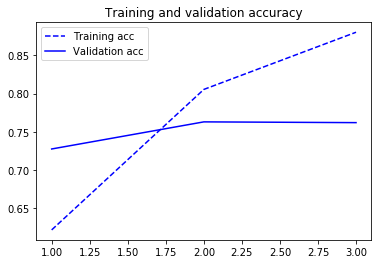

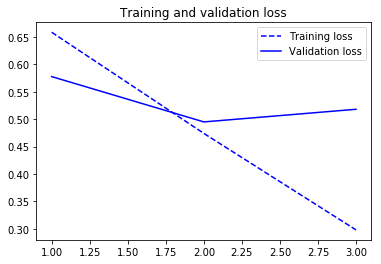

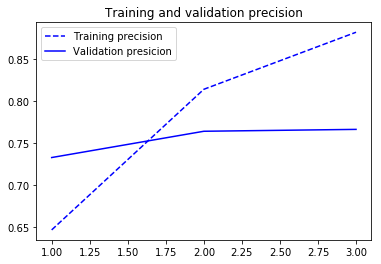

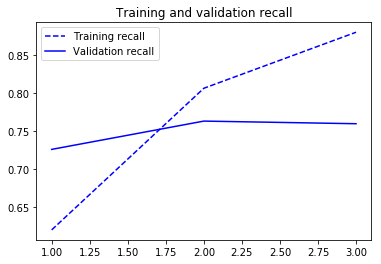

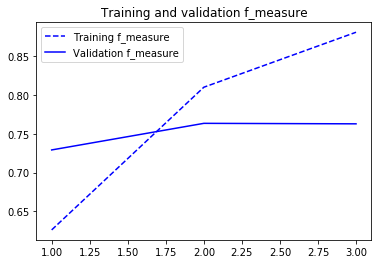

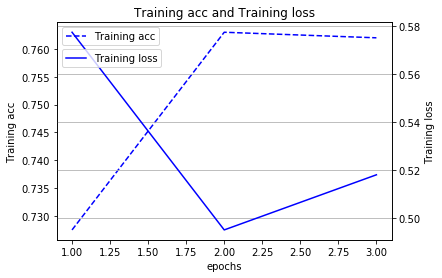

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['macro_precision']
val_precision = history.history['val_macro_precision']
recall = history.history['macro_recall']
val_recall = history.history['val_macro_recall']
f_measure = history.history['macro_f_measure']
val_f_measure = history.history['val_macro_f_measure']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, precision, 'b--', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation presicion')
plt.title('Training and validation precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'b--', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, f_measure, 'b--', label='Training f_measure')
plt.plot(epochs, val_f_measure, 'b', label='Validation f_measure')
plt.title('Training and validation f_measure')
plt.legend()

fig = plt.figure()
ax_acc = fig.add_subplot(111)
ax_acc.plot(epochs, val_acc, 'b--', label='Training acc')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=10)

ax_loss = ax_acc.twinx()
ax_loss.plot(epochs, val_loss, 'b', label='Training loss')
plt.legend(bbox_to_anchor=(0, 0.9), loc='upper left', borderaxespad=0.5, fontsize=10)
plt.title('Training acc and Training loss')
ax_acc.set_xlabel('epochs')
ax_acc.set_ylabel('Training acc')
ax_loss.grid(True)
ax_loss.set_ylabel('Training loss')

plt.savefig("acc_loss.png")
plt.show()


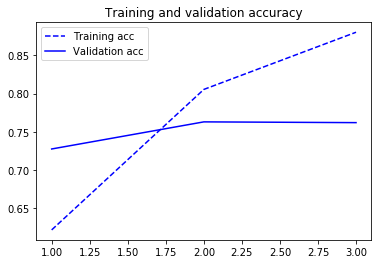

In [11]:
plt.plot(epochs, acc, 'b--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("RNN_tweet/Figs/A_data/A_accuracy.png")
plt.show()

In [ ]:
RNN_tweet/Figs/A_data/